# ***Machine Learning Base Model***

## 📚 ***Import libraries***

In [1]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline

## 💾 ***Load data***

In [2]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"

nyc_houses_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/nyc_houses_semi_cleaned.parquet", engine="pyarrow"
)

In [3]:
nyc_houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29179 entries, 0 to 29178
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   COMMERCIAL UNITS           29178 non-null  Int64  
 1   TAX CLASS AT TIME OF SALE  29179 non-null  float64
 2   RESIDENTIAL UNITS          29179 non-null  Int64  
 3   GROSS SQUARE FEET          22359 non-null  float64
 4   BOROUGH                    29179 non-null  float64
 5   SALE PRICE                 29179 non-null  float64
 6   YEAR BUILT                 27797 non-null  float64
 7   LAND SQUARE FEET           22700 non-null  float64
dtypes: Int64(2), float64(6)
memory usage: 1.8 MB


In [4]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)

Pandas version:  2.2.3


## 👷 ***Data preparation***

***Adaptation of heuristics, after Feature Engineering:*** we eliminated neighborhood as it was not in the dataset, kept total_units as the sum of COMMERCIAL UNITS and RESIDENTIAL UNITS, and adjusted the heuristic to use only the available columns.

In [5]:
def estimate_sale_price(df, borough, gross_sqft, total_units, land_sqft) -> float:
    """Estimate the sale price of a property using data-driven heuristics.

    Args:
        df (pd.DataFrame): DataFrame containing real estate transaction data.
        borough (int): Borough ID (1=Manhattan, 2=Bronx, 3=Brooklyn, 4=Queens, 5=Staten Island).
        gross_sqft (float): Gross square footage of the property.
        total_units (int): Total number of units in the building.
        land_sqft (float): Total land square footage.

    Returns:
        float: Estimated sale price based on heuristic rules.
    """

    # Ensure that price and area data are valid
    valid_data = df[(df["GROSS SQUARE FEET"] > 0) & (df["SALE PRICE"] > 0)].copy()

    if valid_data.empty:
        raise ValueError("No valid property data found. Check input values.")

    # Calculate price per square foot (capped at $1000/sqft to avoid extreme values)
    price_per_sqft = (valid_data["SALE PRICE"] / valid_data["GROSS SQUARE FEET"]).median()
    price_per_sqft = min(price_per_sqft, 1000)

    base_price = gross_sqft * price_per_sqft

    # Borough adjustment based on observed median prices
    borough_medians = valid_data.groupby("BOROUGH")["SALE PRICE"].median().to_dict()
    borough_median_price = borough_medians.get(borough, valid_data["SALE PRICE"].median())
    borough_adjustment = borough_median_price / valid_data["SALE PRICE"].median()

    adjusted_price = base_price * borough_adjustment

    # Adjustment based on the total number of units (affects up to 10 units, then stabilizes)
    unit_adjustment = 1 + (min(total_units, 10) / 50)
    adjusted_price *= unit_adjustment

    # Adjustment based on land area (capped at 10,000 sqft)
    land_adjustment = min(land_sqft, 10000) * 1
    final_price = adjusted_price + land_adjustment

    # Ensure a minimum price of $50,000
    return max(final_price, 50000)

Base on the rules above, for the heuristic model only 5 columns are needed: "BOROUGH", "GROSS SQUARE FEET", "RESIDENTIAL UNITS", "COMMERCIAL UNITS" and "LAND SQUARE FEET".

In [6]:
selected_features = ["BOROUGH", "GROSS SQUARE FEET", "RESIDENTIAL UNITS", "COMMERCIAL UNITS", "LAND SQUARE FEET", "SALE PRICE"]
nyc_houses_features = nyc_houses_df[selected_features]
nyc_houses_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29179 entries, 0 to 29178
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BOROUGH            29179 non-null  float64
 1   GROSS SQUARE FEET  22359 non-null  float64
 2   RESIDENTIAL UNITS  29179 non-null  Int64  
 3   COMMERCIAL UNITS   29178 non-null  Int64  
 4   LAND SQUARE FEET   22700 non-null  float64
 5   SALE PRICE         29179 non-null  float64
dtypes: Int64(2), float64(4)
memory usage: 1.4 MB


In [7]:
nyc_houses_features["BOROUGH"] = nyc_houses_features["BOROUGH"].astype('category')

C:\Users\SOULG\AppData\Local\Temp\ipykernel_20512\2831245920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_houses_features["BOROUGH"] = nyc_houses_features["BOROUGH"].astype('category')


In [8]:
nyc_houses_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29179 entries, 0 to 29178
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   BOROUGH            29179 non-null  category
 1   GROSS SQUARE FEET  22359 non-null  float64 
 2   RESIDENTIAL UNITS  29179 non-null  Int64   
 3   COMMERCIAL UNITS   29178 non-null  Int64   
 4   LAND SQUARE FEET   22700 non-null  float64 
 5   SALE PRICE         29179 non-null  float64 
dtypes: Int64(2), category(1), float64(3)
memory usage: 1.2 MB


In [9]:
nyc_houses_features.isna().sum()

BOROUGH                 0
GROSS SQUARE FEET    6820
RESIDENTIAL UNITS       0
COMMERCIAL UNITS        1
LAND SQUARE FEET     6479
SALE PRICE              0
dtype: int64

In [10]:
len(nyc_houses_features.drop_duplicates())

25494

Dropping duplicates in the dataset is important to avoid bias and data leakage when training a machine learning model. However, for a heuristic model, duplicates do not impact performance. Since the dataset has been reduced to key columns, there may be more duplicates, but they will not be removed to maintain consistency and allow comparisons with machine learning models that use more variables.

In [11]:
nyc_houses_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29179 entries, 0 to 29178
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   BOROUGH            29179 non-null  category
 1   GROSS SQUARE FEET  22359 non-null  float64 
 2   RESIDENTIAL UNITS  29179 non-null  Int64   
 3   COMMERCIAL UNITS   29178 non-null  Int64   
 4   LAND SQUARE FEET   22700 non-null  float64 
 5   SALE PRICE         29179 non-null  float64 
dtypes: Int64(2), category(1), float64(3)
memory usage: 1.2 MB


In [12]:
nyc_houses_features.sample(5, random_state=42)

,BOROUGH,GROSS SQUARE FEET,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,SALE PRICE
8978,3.0,1300.0,1,0,2000.0,450000.0
24392,3.0,2698.0,2,0,2051.0,1230000.0
20217,4.0,1040.0,1,0,5000.0,850000.0
11617,5.0,2910.0,2,0,3840.0,520000.0
27930,4.0,4000.0,0,1,4000.0,2925000.0


GROSS SQUARE FEET, COMMERCIAL UNITS, LAND SQUARE FEET column needs imputation, for this model, we will use the median value. but categorical columns don’t need nothing for this heuristic model.

In [13]:
numeric_features = ["GROSS SQUARE FEET", "LAND SQUARE FEET", "COMMERCIAL UNITS", "RESIDENTIAL UNITS"]
categorical_features = ["BOROUGH"]

In [14]:
# Function to restore feature names after ColumnTransformer processing
def restore_feature_names(X):
    return pd.DataFrame(X, columns=numeric_features + categorical_features)

In [15]:
numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("categoric", "passthrough", categorical_features),
        ("numeric", numeric_pipe, numeric_features),
    ],
    remainder="passthrough"  # Ensure no columns are dropped
)

In [16]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('categoric', 'passthrough', ['BOROUGH']),
                                ('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['GROSS SQUARE FEET', 'LAND SQUARE FEET',
                                  'COMMERCIAL UNITS', 'RESIDENTIAL UNITS'])])

In [17]:
data_example = nyc_houses_features.drop(columns="SALE PRICE").sample(10, random_state=42)
data_example

,BOROUGH,GROSS SQUARE FEET,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET
8978,3.0,1300.0,1,0,2000.0
24392,3.0,2698.0,2,0,2051.0
20217,4.0,1040.0,1,0,5000.0
11617,5.0,2910.0,2,0,3840.0
27930,4.0,4000.0,0,1,4000.0
12522,3.0,NaN,1,0,NaN
3077,3.0,NaN,1,0,NaN
27012,3.0,3000.0,3,0,1500.0
12129,2.0,2070.0,1,0,2970.0
8810,3.0,NaN,0,0,NaN


In [18]:
preprocessor.fit_transform(data_example)

array([[ 3.        , -1.49312987, -1.03476197, -0.33333333, -0.22941573],
       [ 3.        ,  0.23028126, -0.98338152, -0.33333333,  0.91766294],
       [ 4.        , -1.81364982,  1.98761745, -0.33333333, -0.22941573],
       [ 5.        ,  0.49162829,  0.81896408, -0.33333333,  0.91766294],
       [ 4.        ,  1.83534655,  0.98015764,  3.        , -1.3764944 ],
       [ 3.        ,  0.23028126, -0.05752595, -0.33333333, -0.22941573],
       [ 3.        ,  0.23028126, -0.05752595, -0.33333333, -0.22941573],
       [ 3.        ,  0.60257751, -1.53849187, -0.33333333,  2.0647416 ],
       [ 2.        , -0.5438977 , -0.05752595, -0.33333333, -0.22941573],
       [ 3.        ,  0.23028126, -0.05752595, -0.33333333, -1.3764944 ]])

***Train / Test split***

In [19]:
# Control
nyc_houses_features = nyc_houses_features[nyc_houses_features["SALE PRICE"] > 0]

X_features = nyc_houses_features.drop("SALE PRICE", axis="columns")
Y_target = nyc_houses_features["SALE PRICE"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, random_state=42
)

In [20]:
x_train.shape, y_train.shape

((23343, 5), (23343,))

In [21]:
x_test.shape, y_test.shape

((5836, 5), (5836,))

***Model***

In [22]:
class HeuristicModel(BaseEstimator, RegressorMixin):
    """Heuristic model for NYC HOUSES dataset compatible with scikit-learn."""

    def fit(self, X, y):
        """Stores necessary statistics for the heuristic model."""

        # Ensure X is a DataFrame, even after pipeline transformations
        if isinstance(X, np.ndarray):
            raise ValueError("Feature names are missing. Make sure the pipeline retains feature names.")

        # Store feature names to reattach later
        self.feature_names_ = X.columns.tolist()

        # Store median price per square foot
        self.median_price_per_sqft_ = (y / X["GROSS SQUARE FEET"]).median()

        # Store borough median prices
        self.borough_medians_ = y.groupby(X["BOROUGH"]).median().to_dict()

        return self

    def predict(self, X):
        """Predicts house sale prices based on heuristics."""

        # If X is a NumPy array, reattach column names
        if isinstance(X, np.ndarray):
            if not hasattr(self, "feature_names_"):
                raise ValueError("Feature names are missing. Make sure fit() was called first.")
            X = pd.DataFrame(X, columns=self.feature_names_)

        predictions = []

        for _, row in X.iterrows():
            price_per_sqft = min(self.median_price_per_sqft_, 1000)
            base_price = row["GROSS SQUARE FEET"] * price_per_sqft

            borough_adjustment = self.borough_medians_.get(row["BOROUGH"], self.median_price_per_sqft_) / self.median_price_per_sqft_
            adjusted_price = base_price * borough_adjustment

            total_units = row["COMMERCIAL UNITS"] + row["RESIDENTIAL UNITS"]
            unit_adjustment = 1 + (min(total_units, 10) / 50)
            adjusted_price *= unit_adjustment

            land_adjustment = min(row["LAND SQUARE FEET"], 10000)
            final_price = adjusted_price + land_adjustment

            predictions.append(max(final_price, 50000))

        return np.array(predictions)


***Predict and Evaluation***

In [23]:
# Model
model = HeuristicModel()

# Evaluation metrics
scoring_metrics = ["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]

# KFold for cross-validation
kfold = KFold(n_splits=10)

# Model pipeline = preprocessor + model
model_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),  # Preprocessing step
    ("feature_names_restorer", FunctionTransformer(restore_feature_names, validate=False)),  # Fix feature names
    ("model", HeuristicModel())  # Model step comes last
])

# Variable to store the results of the cross-validation
cv_results = {}
train_results = {}

In [24]:
# Cross-validation evaluation for each metric
for metric in scoring_metrics:
    cv_results[metric] = cross_val_score(
        model_pipe, x_train, y_train, cv=kfold, scoring=metric
    )
    # Evaluate on the training set
    model_pipe.fit(x_train, y_train)
    y_train_pred = model_pipe.predict(x_train)
    
    # Compute metrics for training set
    if metric == "neg_mean_absolute_error":
        train_results[metric] = -mean_absolute_error(y_train, y_train_pred)
    elif metric == "neg_mean_squared_error":
        train_results[metric] = -mean_squared_error(y_train, y_train_pred)
    elif metric == "r2":
        train_results[metric] = r2_score(y_train, y_train_pred)

In [25]:
# Convert results into a pandas DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Print the mean and standard deviation for each metric
for metric_name in scoring_metrics:
    print(
        f"{metric_name} - CV mean: {cv_results_df[metric_name].mean()}, "
        f"CV std: {cv_results_df[metric_name].std()}"
    )
    print(f"{metric_name} - Train score: {train_results[metric_name]}")

neg_mean_absolute_error - CV mean: -883939.7294046485, CV std: 29200.661293907444
neg_mean_absolute_error - Train score: -883939.1302317611
neg_mean_squared_error - CV mean: -2409755611601.201, CV std: 263048144393.0388
neg_mean_squared_error - Train score: -2409751222679.0522
r2 - CV mean: -0.48404742119244515, CV std: 0.040677337917665264
r2 - Train score: -0.4789353482440555


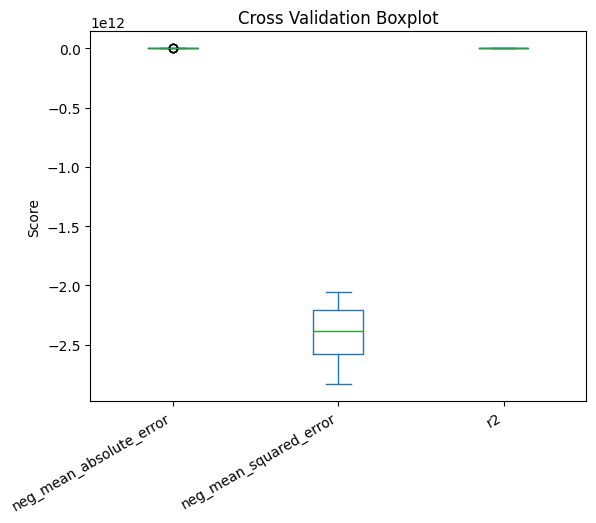

In [26]:
# Create a boxplot for the cross-validation results of each metric
ax_ = cv_results_df.plot.box(title="Cross Validation Boxplot", ylabel="Score")
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30, ha="right");

<Figure size 600x400 with 0 Axes>

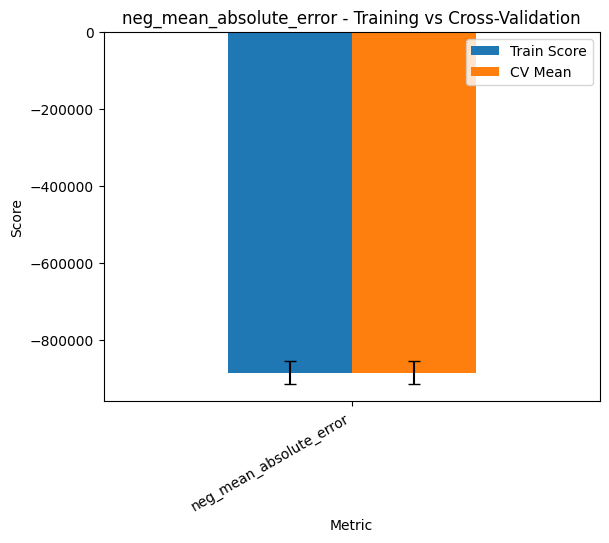

<Figure size 600x400 with 0 Axes>

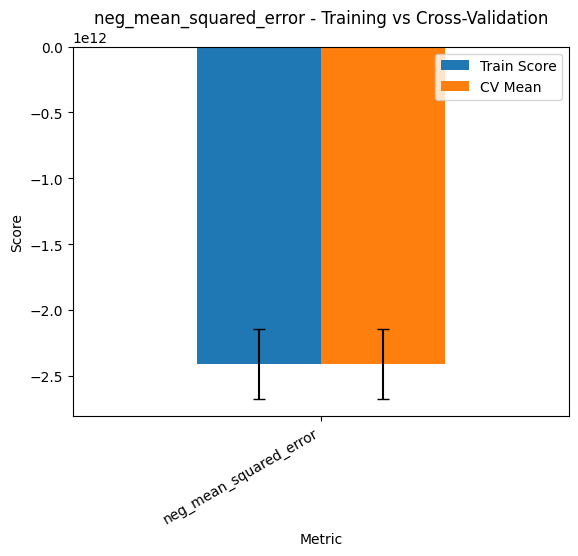

<Figure size 600x400 with 0 Axes>

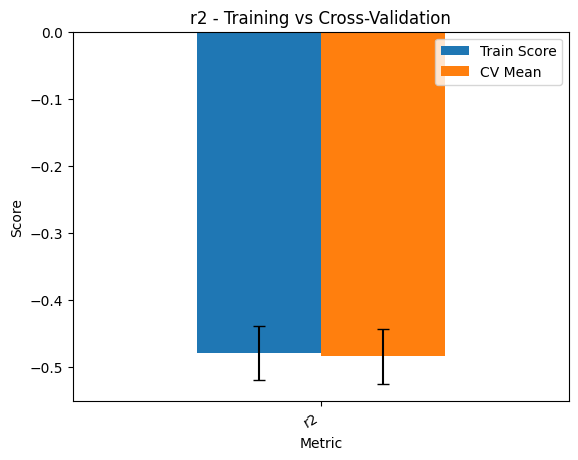

In [27]:
# Create a DataFrame for the training and cross-validation metrics
metrics_df = pd.DataFrame(
    {
        "Metric": scoring_metrics,
        "Train Score": [train_results[metric] for metric in scoring_metrics],
        "CV Mean": [cv_results_df[metric].mean() for metric in scoring_metrics],
        "CV Std": [cv_results_df[metric].std() for metric in scoring_metrics],
    }
)

# Iterate over each metric and plot it separately
for metric in scoring_metrics:
    plt.figure(figsize=(6, 4))  # Adjust figure size
    
    # Create a DataFrame with only the current metric
    metric_df = metrics_df[metrics_df["Metric"] == metric]

    # Plot the metric
    ax = metric_df.plot(
        kind="bar",
        x="Metric",
        y=["Train Score", "CV Mean"],
        yerr="CV Std",
        title=f"{metric} - Training vs Cross-Validation",
        ylabel="Score",
        capsize=4,
        legend=True,
    )

    # Rotate labels for better clarity
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

    plt.show()

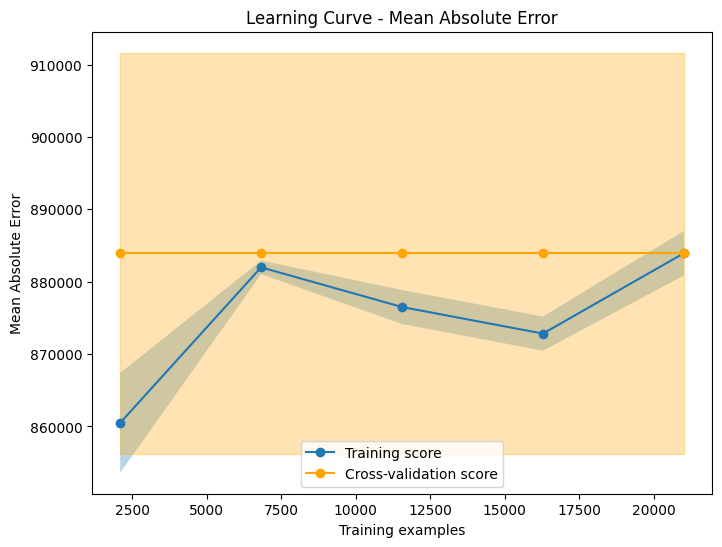

In [28]:
# Parameters for the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model_pipe, x_train, y_train, cv=kfold, 
    train_sizes=np.linspace(0.1, 1.0, 5), 
    scoring="neg_mean_absolute_error", 
    n_jobs=-1
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, -train_mean, "o-", label="Training score")
plt.plot(train_sizes, -test_mean, "o-", label="Cross-validation score", color="orange")
plt.fill_between(train_sizes, -train_mean - train_std, -train_mean + train_std, alpha=0.3)
plt.fill_between(train_sizes, -test_mean - test_std, -test_mean + test_std, alpha=0.3, color="orange")

plt.title("Learning Curve - Mean Absolute Error")
plt.xlabel("Training examples")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()


# 😢😢😢 ***Analysis of the Results of All Metrics***

## **Mean Absolute Error (MAE)**
- **CV Mean**: -883,939.73  
- **CV Std**: 29,200.66  
- **Train Score**: -883,939.13  
- **Interpretation**:  
  The mean absolute error in cross-validation is almost identical to the training error, suggesting that the model is not overfitting. However, the absolute error value is quite high, indicating that the model struggles to predict housing prices accurately. The standard deviation of 29,200 suggests moderate variability in the model’s predictions across different folds.

## **Mean Squared Error (MSE)**
- **CV Mean**: -2,409,755,611,601.20  
- **CV Std**: 263,048,144,393.04  
- **Train Score**: -2,409,751,222,679.05  
- **Interpretation**:  
  The mean squared error is extremely high, indicating that some predictions have significant errors. The large standard deviation also suggests that the model struggles with certain subsets of the data and may be influenced by outliers.

## **R² Score**
- **CV Mean**: -0.484  
- **CV Std**: 0.041  
- **Train Score**: -0.479  
- **Interpretation**:  
  A negative R² score means that the model performs worse than a baseline model that simply predicts the average housing price. This suggests that the relationship between the input variables and the target price is not well captured. Additionally, the low standard deviation indicates that this poor performance is consistent across different validation folds.

# 🧑‍🔬 ***Recommendations***
***Do NOT Continue with the Current Model:*** Given the poor generalization and negative performance indicators (e.g., negative R² score), this model is not suitable for deployment. The extreme errors indicate that it does not effectively capture the underlying patterns in the data.

***Reassess Feature Engineering & Model Selection:*** The current model is likely too simplistic or not well suited for the data. Further exploration of alternative regression models and feature transformations is necessary before proceeding.

***Address Model Limitations:*** The high error values and negative R² suggest potential issues with outliers, data transformations, or feature selection. Improvements in these areas should be prioritized before fine-tuning hyperparameters.

# 💡 ***Proposals and Ideas***
## ***Use More Robust Models***
***Proposal:*** Test alternative models such as Random Forest, Gradient Boosting Machines (XGBoost, LightGBM), etc.

# 📌 ***Conclusion***
The current model is not reliable for predicting NYC house prices. The negative R² score and large errors indicate significant room for improvement.

***Next Steps:***
Experiment with alternative regression models to find a better fit for the dataset. 

# 🚀